# Simple GNN
Build a simple GNN model with PyTorch Geometric.
* Dataset: Cora
* Model: GCN

Execute only colab

In [1]:
# install torch-geometric and related libraries
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


## Load dataset

In [2]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


## Visualize dataset

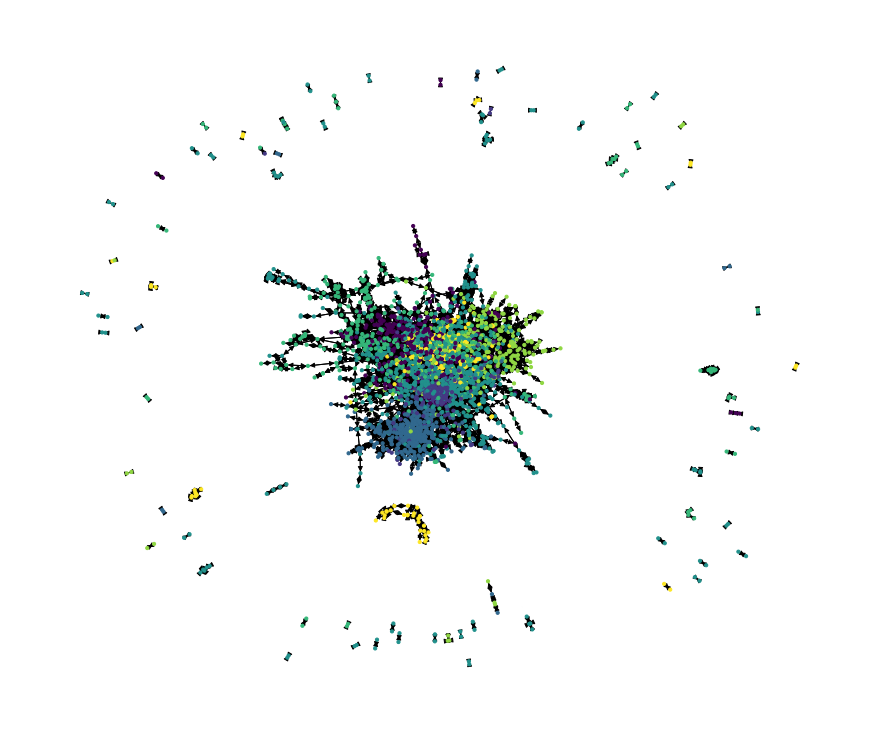

In [4]:
# visualize the graph structure with networkx and matplotlib
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

data_nx = to_networkx(data)
plt.figure(figsize=(12,10))
nx.draw(data_nx, node_color=data.y, node_size=10)
plt.show()

## Build model

In [5]:
# Define a simple GNN model
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(32, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

net = Net()
net.cuda() # run on GPU

Net(
  (conv1): GCNConv(1433, 32)
  (relu): ReLU()
  (conv2): GCNConv(32, 7)
)

## Train model

In [6]:
# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

data = data.cuda() # run on GPU

# train the model
net.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = net(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

## Evaluate model

In [10]:
# evaluate the model
net.eval()
pred = net(data).argmax(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum().item() * 100
print('Accuracy: {:.2f}'.format(acc), "%")

Accuracy: 78.80 %
